# BERT Model

In [1]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re

import collections
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from pathlib import Path
import random
import seaborn as sns
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import classification_report, confusion_matrix, multilabel_confusion_matrix, f1_score, accuracy_score, hamming_loss
from sklearn.model_selection import train_test_split
import tensorflow as tf
import torch
import torch.nn as nn
from torch.nn import BCEWithLogitsLoss, BCELoss
from torch.optim import AdamW
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler, Dataset
from transformers import BertForSequenceClassification, BertTokenizer
from tqdm import tqdm, trange
from typing import Dict, List, Tuple

%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings("ignore")

def warn(*args, **kwargs):
    pass

warnings.warn = warn

In [3]:
SEED = 1234

def set_seeds(seed=1234):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed) # multi-GPU

set_seeds(seed=SEED)

# Set device
cuda = True
device = torch.device("cuda" if (
    torch.cuda.is_available() and cuda
    ) else
        "cpu")

torch.set_default_tensor_type("torch.FloatTensor")

if device.type == "cuda":
    torch.set_default_tensor_type("torch.cuda.FloatTensor")

import tensorflow as tf

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [4]:
n_gpu = torch.cuda.device_count()
print(n_gpu)
torch.cuda.get_device_name(0)

1


'Tesla T4'

In [5]:
dir = Path("data")
file_path = Path(dir, "MultiLabelTextClassificationDataset.csv")  # data/MultiLabelTextClassificationDataset.csv

# header=0 signifies that the first row (0th index) is a header row containing the names of each column in the dataset
df = pd.read_csv(file_path, header=0)
df.head(3)

,Title,abstractText,meshMajor,pmid,meshid,meshroot,A,B,C,D,E,F,G,H,I,J,L,M,N,Z
0,Expression of p53 and coexistence of HPV in pr...,Fifty-four paraffin embedded tissue sections f...,"['DNA Probes, HPV', 'DNA, Viral', 'Female', 'H...",8549602,"[['D13.444.600.223.555', 'D27.505.259.750.600....","['Chemicals and Drugs [D]', 'Organisms [B]', '...",0,1,1,1,1,0,0,1,0,0,0,0,0,0
1,Vitamin D status in pregnant Indian women acro...,The present cross-sectional study was conducte...,"['Adult', 'Alkaline Phosphatase', 'Breast Feed...",21736816,"[['M01.060.116'], ['D08.811.277.352.650.035'],...","['Named Groups [M]', 'Chemicals and Drugs [D]'...",0,1,1,1,1,1,1,0,1,1,0,1,1,1
2,[Identification of a functionally important di...,The occurrence of individual amino acids and d...,"['Amino Acid Sequence', 'Analgesics, Opioid', ...",19060934,"[['G02.111.570.060', 'L01.453.245.667.060'], [...","['Phenomena and Processes [G]', 'Information S...",1,1,0,1,1,0,1,0,0,0,1,0,0,0


In [ ]:
for col in df.columns:
    print(f"Column name: {col}")
    print(f"Column data type: {df[col].dtype}")
    print(f"Number of unique elements in {col}: {len(df[col].unique())}\n")

In [6]:
# Rows with at least one NaN value
df[pd.isnull(df).any(axis=1)].head()
df = df.dropna() # removes rows with any NaN values
df = df.reset_index() # reset's row indexes in case any rows were dropped
print(df.shape)
df.head(3)

(49998, 21)


,index,Title,abstractText,meshMajor,pmid,meshid,meshroot,A,B,C,...,E,F,G,H,I,J,L,M,N,Z
0,0,Expression of p53 and coexistence of HPV in pr...,Fifty-four paraffin embedded tissue sections f...,"['DNA Probes, HPV', 'DNA, Viral', 'Female', 'H...",8549602,"[['D13.444.600.223.555', 'D27.505.259.750.600....","['Chemicals and Drugs [D]', 'Organisms [B]', '...",0,1,1,...,1,0,0,1,0,0,0,0,0,0
1,1,Vitamin D status in pregnant Indian women acro...,The present cross-sectional study was conducte...,"['Adult', 'Alkaline Phosphatase', 'Breast Feed...",21736816,"[['M01.060.116'], ['D08.811.277.352.650.035'],...","['Named Groups [M]', 'Chemicals and Drugs [D]'...",0,1,1,...,1,1,1,0,1,1,0,1,1,1
2,2,[Identification of a functionally important di...,The occurrence of individual amino acids and d...,"['Amino Acid Sequence', 'Analgesics, Opioid', ...",19060934,"[['G02.111.570.060', 'L01.453.245.667.060'], [...","['Phenomena and Processes [G]', 'Information S...",1,1,0,...,1,0,1,0,0,0,1,0,0,0


In [7]:
nltk.download("stopwords")
STOPWORDS = stopwords.words("english")
print(STOPWORDS[:5])
porter = PorterStemmer()

['i', 'me', 'my', 'myself', 'we']


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
def preprocess(text, stopwords=STOPWORDS):
    text = text.lower()

    # Remove stopwords
    pattern = re.compile(r"\b(" + r"|".join(stopwords) + r")\b\s*")
    text = pattern.sub("", text)

    # Remove words in parenthesis
    text = re.sub(r"\([^)]*\)", "", text)

    # Spacing and filters
    text = re.sub(r"([-;;.,!?<=>])", r" \1 ", text)  # separate punctuation tied to words
    text = re.sub("[^A-Za-z0-9]+", " ", text)  # remove non alphanumeric chars
    text = re.sub(" +", " ", text)  # remove multiple spaces
    text = text.strip()

    return text

# Example:
text = "Great week to interview with Rhino health!"
preprocess(text=text)

'great week interview rhino health'

In [9]:
%%time


preprocessed_df = df.copy()
df.abstractText = preprocessed_df.abstractText.apply(preprocess)
print(
    f"{df.abstractText.values[0]}\n\n{preprocessed_df.abstractText.values[0]}\n"
)

fifty four paraffin embedded tissue sections patients dysplasia cervical cancer analysed hpv detected identified two stages firstly using mixed starters chosen genomic dna sequences amplified secondly material thus obtained analyzed hybridization method using oligonucleotyde 31 p labelled probe hpvs type 6 11 16 18 33 identified p 53 expression assayed immunohistochemical method hpv infection often associated dysplasia cervical cancer cervical cancer mainly hpv 16 18 high oncogenic potential found p 53 present rarely minute quantities correlation observed presence p 53 hpvs dna

Fifty-four paraffin embedded tissue sections from patients with dysplasia (21 cases) and with cervical cancer (33 cases) were analysed. HPV was detected and identified in two stages. Firstly, using mixed starters, chosen genomic DNA sequences were amplified; secondly the material thus obtained was analyzed by hybridization method using oligonucleotyde 31-P labelled probe. HPVs of type 6, 11, 16, 18, 33 were ide

In [10]:
"""
    Split dataset so that each of the three splits has the same distribution of classes

    train: used to train our model.
    val : used to validate our model's performance during training.
    test: used to do an evaluation of our fully trained model.
"""


def train_val_test_split(df):
    # 70-30 split
    df_train, df_temp = train_test_split(
        df, test_size=0.3, random_state=SEED, shuffle=True
    )

    # 15-15 split
    df_validation, df_test = train_test_split(
        df_temp, test_size=0.5, random_state=SEED, shuffle=True
    )

    return df_train, df_validation, df_test


df_train, df_validation, df_test = train_val_test_split(df)
print(f"Training data: {df_train.shape}. {round(df_train.shape[0]/df.shape[0]*100, 2)}% of dataset")
print(f"Validation data: {df_validation.shape}. {round(df_validation.shape[0]/df.shape[0]*100, 2)}% of dataset")
print(f"Testing data: {df_test.shape}. {round(df_test.shape[0]/df.shape[0]*100, 2)}% of dataset")

Training data: (34998, 21). 70.0% of dataset
Validation data: (7500, 21). 15.0% of dataset
Testing data: (7500, 21). 15.0% of dataset


In [11]:
print (f"Sample point: \n{df_train.abstractText[24515]}\n")
print(f"Sample labels: \n{df_train.iloc[24515][7:]}")

Sample point: 
second harmonic generation imaging microscopy important emerging technique biological research complementing existing one two photon fluorescence methods non linear phenomenon employing light mode locked ti sapphire fiber based lasers shg results intrinsic optical sectioning without need confocal aperture furthermore second order process shg confined loci lacking center symmetry constraint readily satisfied lipid membranes one leaflet stained dye particular interest resonance enhanced shg styryl dyes cellular membranes possibility shg sensitive transmembrane potential previously confirmed using simultaneous voltage clamping non linear imaging cells find shg four times sensitive potential fluorescence work extended results two directions first range wavelengths available mode locked ti sapphire laser fiber based laser fully investigated shg 2pf voltage sensitivity anep astap chromophores obtaining shg sensitivity spectra consistent resonance enhancements second modified s

### One Hot Encoding: represent a token/tokenized sequence from our vocabulary as one-hot vectors

- One-hot encoding creates a binary column for each unique value for the feature we're trying to map.
- All of the values in each token's array will be 0 except at the index that this specific token is represented by.
- One-hot encoding allows us to represent our data in a way that our models can process the data and isn't biased by the actual value of the token (ex. if your labels were actual numbers).

In [12]:
columns = list(df.columns)
meshroot_encoded = columns[7:]
num_labels = len(meshroot_encoded)
print(f'Mesh Labels Root Class: {meshroot_encoded}')
print(f'Number of Labels: {num_labels}')

Mesh Labels Root Class: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'L', 'M', 'N', 'Z']
Number of Labels: 14


In [13]:
%%time


# retrieve the number of abstracts associated with each mesh major subheading
counts = []
for meshMajor_subheading in meshroot_encoded:
    counts.append(
        (
            meshMajor_subheading,
            df[meshMajor_subheading].sum()
        )
    )
df_count = pd.DataFrame(counts, columns=['Mesh Major Subheading', 'num_associated_abstractTexts'])
df_count

CPU times: user 8.68 ms, sys: 910 µs, total: 9.59 ms
Wall time: 16.7 ms


,Mesh Major Subheading,num_associated_abstractTexts
0,A,23261
1,B,46575
2,C,26451
3,D,31073
4,E,39200
5,F,8885
6,G,33608
7,H,6069
8,I,5595
9,J,5531


In [ ]:
%%time


sns.set(font_scale = 1)
plt.figure(figsize=(14,7))

ax= sns.barplot(x=meshroot_encoded, y=df.iloc[:,7:].sum().values, hue=df.iloc[:,7:].sum().index)

plt.title("Each Root Class", fontsize=20)
plt.ylabel('Number of Articles', fontsize=16)
plt.xlabel('Root Label ', fontsize=18)

rects = ax.patches
labels = df.iloc[:,7:].sum().values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom', fontsize=12)

plt.show()

In [14]:
# Convert meshroot column values to one-hot encoded vectors
df_train['one_hot_labels'] = list(df_train[meshroot_encoded].values)
df_train.head(3)

,index,Title,abstractText,meshMajor,pmid,meshid,meshroot,A,B,C,...,F,G,H,I,J,L,M,N,Z,one_hot_labels
24515,24516,Wavelength- and time-dependence of potentiomet...,second harmonic generation imaging microscopy ...,"['Fiber Optic Technology', 'Fluorescent Dyes',...",16645740,"[['H01.671.617.249'], ['D27.720.233.348', 'D27...","['Disciplines and Occupations [H]', 'Chemicals...",0,0,0,...,0,1,1,0,0,0,0,1,0,"[0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0]"
21369,21370,Parotid masses: MR imaging.,2 year period 20 patients presented masses par...,"['Cadaver', 'Facial Nerve', 'Humans', 'Magneti...",3562818,"[['C23.550.260.224'], ['A08.800.050.050.275', ...","['Diseases [C]', 'Anatomy [A]', 'Organisms [B]...",1,1,1,...,0,0,0,0,0,0,0,0,0,"[1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
7912,7912,Susceptibility and resistance to cyclosporin A...,lethally irradiated lewis rats reconstituted s...,"['Animals', 'Autoimmune Diseases', 'Body Weigh...",8136464,"[['B01.050'], ['C20.111'], ['C23.888.144', 'E0...","['Organisms [B]', 'Diseases [C]', 'Analytical,...",1,1,1,...,0,1,0,0,0,0,0,0,0,"[1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0]"


In [15]:
train_labels = list(df_train.one_hot_labels.values)
training_articles = list(df_train.abstractText.values)

### Tokenize: Convert text to tokens (from char/word/sub-word, in our vocabulary) and map to unique indices

- Input data is text and we can't feed it directly to our models.
- Use a Tokenizer to convert text input data into token indices
- Every token (we can decide what a token is char, word, sub-word, etc.) is mapped to a unique index which allows us to represent our text as an array of indices.

In [16]:
%%time


max_length = 128

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

encodings = tokenizer.batch_encode_plus(training_articles, max_length=max_length, padding=True, truncation=True) # tokenizer's encoding method
print('Tokenizer outputs: ', encodings.keys())

input_ids = encodings['input_ids'] # tokenized and encoded sentences
attention_masks = encodings['attention_mask'] # attention masks

Tokenizer outputs:  dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])
CPU times: user 2min 48s, sys: 727 ms, total: 2min 49s
Wall time: 3min 15s


BERT requires specifically formatted inputs. For each tokenized input sentence, we need to create:

- **input ids**: a sequence of integers identifying each input token to its index number in the BERT tokenizer vocabulary
- **segment mask**: (optional) a sequence of 1s and 0s used to identify whether the input is one sentence or two sentences long. For one sentence inputs, this is simply a sequence of 0s. For two sentence inputs, there is a 0 for each token of the first sentence, followed by a 1 for each token of the second sentence
- **attention mask**: (optional) a sequence of 1s and 0s, with 1s for all input tokens and 0s for all padding tokens (we'll detail this in the next paragraph)
- **labels**: a single value of 1 or 0. In our task 1 means "grammatical" and 0 means "ungrammatical"

Although we can have variable length input sentences, BERT does requires our input arrays to be the same size. We address this by first choosing a maximum sentence length, and then padding and truncating our inputs until every input sequence is of the same length.

To "pad" our inputs in this context means that if a sentence is shorter than the maximum sentence length, we simply add 0s to the end of the sequence until it is the maximum sentence length.

If a sentence is longer than the maximum sentence length, then we simply truncate the end of the sequence, discarding anything that does not fit into our maximum sentence length.

We pad and truncate our sequences so that they all become of length MAX_LEN ("post" indicates that we want to pad and truncate at the end of the sequence, as opposed to the beginning) `pad_sequences` is a utility function that we're borrowing from Keras. It simply handles the truncating and padding of Python lists.

In [17]:
%%time


train_inputs, validation_inputs, train_labels, validation_labels, train_masks, validation_masks = train_test_split(
        input_ids, train_labels, attention_masks, random_state=SEED, test_size=0.20
    )

CPU times: user 38.2 ms, sys: 986 µs, total: 39.2 ms
Wall time: 46 ms


In [18]:
print(type(train_inputs))  # List
print(type(train_inputs[0]))  # List[int]
print(train_inputs[0])

<class 'list'>
<class 'list'>
[101, 2206, 24269, 3447, 11432, 1041, 15549, 5302, 8017, 8310, 2186, 1018, 1050, 2632, 3683, 18037, 11368, 29598, 6675, 3695, 18037, 10609, 10431, 2063, 16942, 2002, 24952, 2278, 12702, 25426, 2389, 12098, 8516, 18479, 26190, 18479, 18037, 25002, 3450, 2561, 22330, 3406, 20366, 1052, 10332, 3798, 2572, 18939, 18804, 14956, 4221, 22330, 3406, 20366, 1052, 10332, 17435, 3375, 4195, 2092, 23900, 11498, 18647, 6550, 14255, 18479, 20200, 5377, 1050, 2632, 3683, 18037, 4942, 16643, 8525, 4765, 11709, 3445, 20519, 2491, 5300, 4852, 6351, 4677, 3091, 2632, 3683, 18037, 4942, 16643, 8525, 4765, 2979, 15502, 3643, 10099, 4820, 2274, 2416, 6351, 13353, 3525, 10548, 3020, 24004, 24277, 2015, 6289, 2232, 4023, 3811, 23900, 7399, 6550, 2561, 22330, 3406, 20366, 1052, 10332, 4180, 8015, 3429, 2629, 13221, 17435, 3375, 102]


In [19]:
# Convert data into torch Long tensors required for the BERT Pytorch model


train_inputs = torch.LongTensor(train_inputs)
train_labels = torch.LongTensor(train_labels)
train_masks = torch.LongTensor(train_masks)

validation_inputs = torch.LongTensor(validation_inputs)
validation_labels = torch.LongTensor(validation_labels)
validation_masks = torch.LongTensor(validation_masks)

## Data Loaders

In [20]:
BATCH_SIZE = 64

train_data = TensorDataset(train_inputs, train_masks, train_labels,)
train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=False)  # Create an iterator avoiding loading entire dataset into memory

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels,)
validation_dataloader = DataLoader(validation_data, batch_size=BATCH_SIZE, shuffle=False)

torch.save(validation_dataloader,'validation_data_loader')
torch.save(train_dataloader,'train_data_loader')

## Load Pre-trained Model

In [21]:
train_data[0]

(tensor([  101,  2206, 24269,  3447, 11432,  1041, 15549,  5302,  8017,  8310,
          2186,  1018,  1050,  2632,  3683, 18037, 11368, 29598,  6675,  3695,
         18037, 10609, 10431,  2063, 16942,  2002, 24952,  2278, 12702, 25426,
          2389, 12098,  8516, 18479, 26190, 18479, 18037, 25002,  3450,  2561,
         22330,  3406, 20366,  1052, 10332,  3798,  2572, 18939, 18804, 14956,
          4221, 22330,  3406, 20366,  1052, 10332, 17435,  3375,  4195,  2092,
         23900, 11498, 18647,  6550, 14255, 18479, 20200,  5377,  1050,  2632,
          3683, 18037,  4942, 16643,  8525,  4765, 11709,  3445, 20519,  2491,
          5300,  4852,  6351,  4677,  3091,  2632,  3683, 18037,  4942, 16643,
          8525,  4765,  2979, 15502,  3643, 10099,  4820,  2274,  2416,  6351,
         13353,  3525, 10548,  3020, 24004, 24277,  2015,  6289,  2232,  4023,
          3811, 23900,  7399,  6550,  2561, 22330,  3406, 20366,  1052, 10332,
          4180,  8015,  3429,  2629, 13221, 17435,  

"bert-base-uncased" means the version that has only lowercase letters ("uncased") and is the smaller version of the two ("base" vs "large").

In [22]:
%%time


model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=num_labels)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


CPU times: user 196 ms, sys: 40.9 ms, total: 237 ms
Wall time: 444 ms


In [23]:
print(model.device)

cuda:0


In [29]:
print(model.cuda())
# model.to(device)
print(model.device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [25]:
# https://huggingface.co/transformers/v3.3.1/training.html
param_optimizer = list(model.named_parameters())

no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {
        'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
        'weight_decay_rate': 0.01
        },
    {
        'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
        'weight_decay_rate': 0.0
        }
]

optimizer = AdamW(optimizer_grouped_parameters,lr=6e-6)

os.environ['TF_FORCE_GPU_ALLOW_GROWTH']='true'

In [26]:
x,y,z = next(iter(train_dataloader))
print(x.size())
print(y.size())
print(z.size())
x[0]

torch.Size([64, 128])
torch.Size([64, 128])
torch.Size([64, 14])


tensor([  101,  2206, 24269,  3447, 11432,  1041, 15549,  5302,  8017,  8310,
         2186,  1018,  1050,  2632,  3683, 18037, 11368, 29598,  6675,  3695,
        18037, 10609, 10431,  2063, 16942,  2002, 24952,  2278, 12702, 25426,
         2389, 12098,  8516, 18479, 26190, 18479, 18037, 25002,  3450,  2561,
        22330,  3406, 20366,  1052, 10332,  3798,  2572, 18939, 18804, 14956,
         4221, 22330,  3406, 20366,  1052, 10332, 17435,  3375,  4195,  2092,
        23900, 11498, 18647,  6550, 14255, 18479, 20200,  5377,  1050,  2632,
         3683, 18037,  4942, 16643,  8525,  4765, 11709,  3445, 20519,  2491,
         5300,  4852,  6351,  4677,  3091,  2632,  3683, 18037,  4942, 16643,
         8525,  4765,  2979, 15502,  3643, 10099,  4820,  2274,  2416,  6351,
        13353,  3525, 10548,  3020, 24004, 24277,  2015,  6289,  2232,  4023,
         3811, 23900,  7399,  6550,  2561, 22330,  3406, 20366,  1052, 10332,
         4180,  8015,  3429,  2629, 13221, 17435,  3375,   102],

In [27]:
# next(enumerate(train_dataloader))[0]  # 0
idx, batch = next(enumerate(train_dataloader))
batch = tuple(t.to(device) for t in batch)  # Add batch to GPU
batch

(tensor([[  101,  2206, 24269,  ..., 17435,  3375,   102],
         [  101,  3800,  2817,  ...,  3463,  2235,   102],
         [  101, 26402,  2098,  ...,     0,     0,     0],
         ...,
         [  101,  2627,  2195,  ...,  1015,  1014,   102],
         [  101,  5385,  2883,  ...,     0,     0,     0],
         [  101, 12058, 10804,  ...,     0,     0,     0]]),
 tensor([[1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]]),
 tensor([[1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0],
         [1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0],
         [1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0],
         [1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
         [1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0],
         [0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0],
         [1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0,

## Training

### Inputs

    - BERT requires specifically formatted inputs. For each tokenized input sentence, we need to create:
    - **input ids**: a sequence of integers identifying each input token to its index number in the BERT tokenizer vocabulary
    - **segment mask**: (optional) a sequence of 1s and 0s used to identify whether the input is one sentence or two sentences long. For one sentence inputs, this is simply a sequence of 0s. For two sentence inputs, there is a 0 for each token of the first sentence, followed by a 1 for each token of the second sentence
    - **attention mask**: (optional) a sequence of 1s and 0s, with 1s for all input tokens and 0s for all padding tokens (we'll detail this in the next paragraph)
    - **labels**: a single value of 1 or 0. In our task 1 means "grammatical" and 0 means "ungrammatical"

    - Modify the pre-trained BERT model to give outputs for multi-label classification, and then we want to continue training the model on our dataset until that the entire model, end-to-end, is well-suited for our task.

    - Huggingface pytorch implementation includes a set of interfaces designed for a variety of NLP tasks, built on top of a trained BERT model. Each has different top layers and output types designed to accomodate their specific NLP task.  
    - We load and use the [BertForSequenceClassification](https://github.com/huggingface/pytorch-pretrained-BERT/blob/master/pytorch_pretrained_bert/modeling.py#L1129).
    - This is the normal BERT model with an added single linear layer on top for classification that we will use as a sentence classifier.
    - As we feed input data, the entire pre-trained BERT model and the additional untrained classification layer is trained on our specific task.


### The Fine-Tuning Process
    - Because the pre-trained BERT layers already encode a lot of information about the language, training the classifier is relatively inexpensive.
    - Rather than training every layer in a large model from scratch, it's as if we have already trained the bottom layers 95% of where they need to be, and only really need to train the top layer, with a bit of tweaking going on in the lower levels to accomodate our task.
    - Sometimes practicioners will opt to "freeze" certain layers when fine-tuning, or to apply different learning rates, apply diminishing learning rates, etc. all in an effort to preserve the good quality weights in the network and speed up training (often considerably).


For each pass in our loop we have a trianing phase and a validation phase.

At each pass we need to:
```
    Training loop:
        - Tell the model to compute gradients by setting the model in train mode
        - Unpack our data inputs and labels
        - Load data onto the GPU for acceleration
        - Clear out the gradients calculated in the previous pass. In pytorch the gradients accumulate by default (useful for things like RNNs) unless you explicitly clear them out
        - Forward pass (feed input data through the network)
        - Backward pass (backpropagation)
        - Tell the network to update parameters with optimizer.step()
        - Track variables for monitoring progress

    Evalution loop:
        - Tell the model not to compute gradients by setting th emodel in evaluation mode
        - Unpack our data inputs and labels
        - Load data onto the GPU for acceleration
        - Forward pass (feed input data through the network)
        - Compute loss on our validation data and track variables for monitoring progress
```

In [30]:
%%time

# https://colab.research.google.com/github/DerwenAI/spaCy_tuTorial/blob/master/BERT_Fine_Tuning.ipynb

train_loss_set = []  # Store our loss and accuracy for plotting
val_f1_accuracy_list, val_flat_accuracy_list, training_loss_list, epochs_list = [], [], [], []
epochs = 5  # between 5 and 10


for _ in trange(epochs, desc="Epoch"):
    model.train()  # Set our model to training mode (as opposed to evaluation mode)

    running_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0

    for step, batch in enumerate(train_dataloader):

        batch = tuple(t.to(device) for t in batch)  # Add batch to GPU
        b_input_ids, b_input_mask, b_labels= batch  # Unpack the inputs from our dataloader

        optimizer.zero_grad()  # Zero all gradients; Clear out the gradients (by default they accumulate)

        # Forward pass for multilabel classification
        # https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html
        # https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html
        # Creates a criterion that measures the Binary Cross Entropy between the target and the input probabilities
        # Also This loss combines a Sigmoid layer and the BCELoss in one single class. This version is more numerically stable
        # than using a plain Sigmoid followed by a BCELoss as, by combining the operations into one layer, we take advantage of the
        # log-sum-exp trick for numerical stability.
        outputs = model(
            b_input_ids,
            token_type_ids=None,
            attention_mask=b_input_mask
        )

        logits = outputs[0]
        loss_func = BCEWithLogitsLoss()
        loss = loss_func(
            logits.view(-1, num_labels),
            b_labels.type_as(logits).view(-1,num_labels)
        )  # Convert labels to float for calculation

        train_loss_set.append(loss.item())

        loss.backward()  # Backward pass
        optimizer.step()  # Update parameters and take a step using the computed gradient

        running_loss += loss.item()
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1

    print(f"Train loss: {running_loss/nb_tr_steps}")
    training_loss_list.append(running_loss/nb_tr_steps)

    model.eval()  # Put model in evaluation mode to evaluate loss on the validation set

    logit_preds, true_labels, pred_labels, tokenized_texts = [], [], [], []

    for i, batch in enumerate(validation_dataloader):
        batch = tuple(t.to(device) for t in batch)

        b_input_ids, b_input_mask, b_labels = batch


        with torch.no_grad(): # Telling the model not to compute or store gradients, saving memory and speeding up validation
            # Forward pass, calculate logit predictions
            outs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
            b_logit_pred = outs[0]
            pred_label = torch.sigmoid(b_logit_pred)

        # Move logits and labels to CPU
        b_logit_pred = b_logit_pred.detach().cpu().numpy()
        pred_label = pred_label.to('cpu').numpy()
        b_labels = b_labels.to('cpu').numpy()

    tokenized_texts.append(b_input_ids)
    logit_preds.append(b_logit_pred)
    true_labels.append(b_labels)
    pred_labels.append(pred_label)

    # Flatten outputs
    pred_labels = [item for sublist in pred_labels for item in sublist]
    true_labels = [item for sublist in true_labels for item in sublist]

    # Calculate Accuracy
    threshold = 0.50
    pred_bools = [pl > threshold for pl in pred_labels]
    true_bools = [tl==1 for tl in true_labels]
    val_f1_accuracy = f1_score(true_bools, pred_bools, average='micro')*100
    val_flat_accuracy = accuracy_score(true_bools, pred_bools)*100

    print('F1 Validation Accuracy: ', val_f1_accuracy)
    print('Flat Validation Accuracy: ', val_flat_accuracy)
    print('\n')
    val_f1_accuracy_list.append(val_f1_accuracy)
    val_flat_accuracy_list.append(val_flat_accuracy)
    epochs_list.append(epochs)

  0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 0.43913228680554045


 20%|██        | 1/5 [11:01<44:05, 661.34s/it]

F1 Validation Accuracy:  83.271375464684
Flat Validation Accuracy:  16.666666666666664


Train loss: 0.34855747488263533


 40%|████      | 2/5 [22:03<33:05, 661.75s/it]

F1 Validation Accuracy:  83.5164835164835
Flat Validation Accuracy:  16.666666666666664


Train loss: 0.32066957414422403


 60%|██████    | 3/5 [33:04<22:03, 661.52s/it]

F1 Validation Accuracy:  86.64259927797833
Flat Validation Accuracy:  20.833333333333336


Train loss: 0.3026971584993955


 80%|████████  | 4/5 [44:05<11:01, 661.29s/it]

F1 Validation Accuracy:  87.45519713261648
Flat Validation Accuracy:  20.833333333333336


Train loss: 0.28897414074096506


100%|██████████| 5/5 [55:05<00:00, 661.07s/it]

F1 Validation Accuracy:  87.76978417266187
Flat Validation Accuracy:  16.666666666666664


CPU times: user 52min 8s, sys: 6.08 s, total: 52min 14s
Wall time: 55min 5s


In [31]:
num_epochs = np.arange(1,len(training_loss_list)+1)
df_train_results=pd.DataFrame(
    {
        'Epochs':num_epochs,'F1 Validation Accuracy':val_f1_accuracy_list,
        'Flat Validation Accuracy':val_flat_accuracy_list,'Train loss':training_loss_list
    }
)

## Visualize Results

Text(0.5, 1.0, 'Training Loss vs Number of Epochs for Bert-Base')

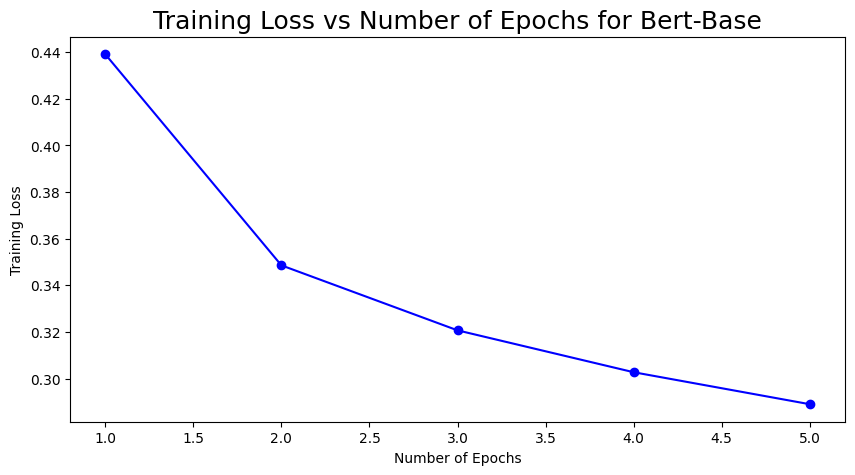

In [32]:
fig, ax = plt.subplots(figsize=(10, 5));
ax.plot(num_epochs, np.array(training_loss_list) ,'bo-',label="Train Loss")
ax.set_xlabel("Number of Epochs")
ax.set_ylabel("Training Loss")
ax.set_title("Training Loss vs Number of Epochs for Bert-Base",fontsize=18)

(0.0, 100.0)

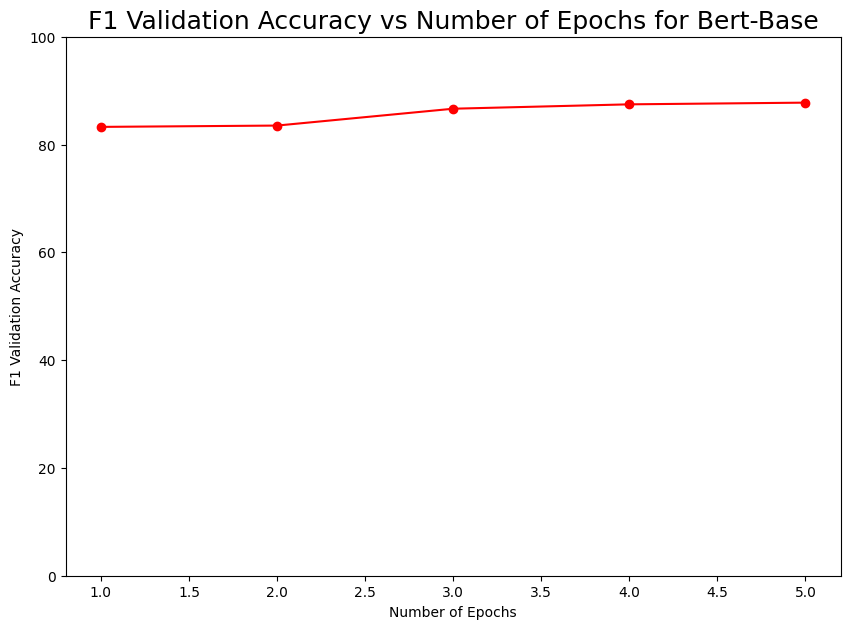

In [33]:
fig, ax = plt.subplots(figsize=(10, 7));
ax.plot(num_epochs, np.array(val_f1_accuracy_list),'ro-' ,label="F1 Validation Accuracy")
ax.set_xlabel("Number of Epochs")
ax.set_ylabel("F1 Validation Accuracy")
ax.set_title("F1 Validation Accuracy vs Number of Epochs for Bert-Base",fontsize=18)
ax.set_ylim(0, 100)

(0.0, 100.0)

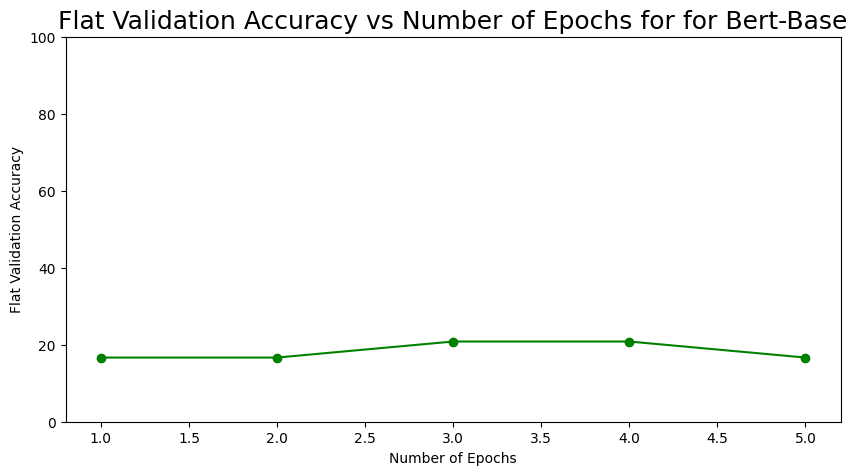

In [34]:
fig, ax = plt.subplots(figsize=(10, 5));
ax.plot(num_epochs, np.array(val_flat_accuracy_list),'go-', label="Flat Validation Accuracy")
ax.set_xlabel("Number of Epochs")
ax.set_ylabel("Flat Validation Accuracy")
ax.set_title("Flat Validation Accuracy vs Number of Epochs for for Bert-Base",fontsize=18)
ax.set_ylim(0, 100)

In [35]:
df_test['one_hot_labels'] = list(df_test[meshroot_encoded].values)
df_test.head(3)

,index,Title,abstractText,meshMajor,pmid,meshid,meshroot,A,B,C,...,F,G,H,I,J,L,M,N,Z,one_hot_labels
20207,20208,A comparison of acuity and treatment measures ...,objective paper used healthcare cost utilizati...,"['California', 'Chest Pain', 'Chi-Square Distr...",21443062,"[['Z01.107.567.875.580.200', 'Z01.107.567.875....","['Geographicals [Z]', 'Diseases [C]', 'Analyti...",0,1,1,...,0,1,0,0,0,0,1,1,1,"[0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1]"
26756,26757,Necessity of a uniform start for scanning afte...,unlabelled authors goal show importance starti...,"['Adult', 'Artifacts', 'Brain', 'Fluorodeoxygl...",16856579,"[['M01.060.116'], ['E05.047'], ['A08.186.211']...","['Named Groups [M]', 'Analytical, Diagnostic a...",1,1,0,...,0,1,0,0,0,1,1,1,0,"[1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0]"
45537,45539,Comparison of mean frequency and median freque...,preferential slow fast twitches fiber involvem...,"['Electromyography', 'Gait', 'Humans', 'Muscle...",28268659,"[['E01.370.405.255', 'E01.370.530.255'], ['E01...","['Analytical, Diagnostic and Therapeutic Techn...",1,1,0,...,0,1,0,0,0,0,1,0,0,"[1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0]"


In [36]:
%%time

test_labels = list(df_test.one_hot_labels.values)
test_articles = list(df_test.abstractText.values)
test_mesh_categories = list(df_test.columns[7:21])

# Encoding input data
test_encodings = tokenizer.batch_encode_plus(test_articles, max_length=max_length, padding=True, truncation=True)
test_input_ids = test_encodings['input_ids']
test_attention_masks = test_encodings['attention_mask']

test_inputs = torch.tensor(test_input_ids)
test_labels = torch.tensor(test_labels)
test_masks = torch.tensor(test_attention_masks)

test_data = TensorDataset(test_inputs, test_masks, test_labels,)# test_token_types)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=BATCH_SIZE)

torch.save(test_dataloader,'test_data_loader')

CPU times: user 30.6 s, sys: 64 ms, total: 30.7 s
Wall time: 30.8 s


## Evaluation

In [37]:
%%time


model.eval()  # evaluation mode

logit_preds,true_labels,pred_labels,tokenized_texts = [],[],[],[]

for i, batch in enumerate(test_dataloader):
    batch = tuple(t.to(device) for t in batch)

    b_input_ids, b_input_mask, b_labels, = batch

    with torch.no_grad():
        # Forward pass
        outs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
        b_logit_pred = outs[0]
        pred_label = torch.sigmoid(b_logit_pred)

        b_logit_pred = b_logit_pred.detach().cpu().numpy()
        pred_label = pred_label.to('cpu').numpy()
        b_labels = b_labels.to('cpu').numpy()

    tokenized_texts.append(b_input_ids)
    logit_preds.append(b_logit_pred)
    true_labels.append(b_labels)
    pred_labels.append(pred_label)

# Flatten outputs
tokenized_texts = [item for sublist in tokenized_texts for item in sublist]
pred_labels = [item for sublist in pred_labels for item in sublist]
true_labels = [item for sublist in true_labels for item in sublist]

# Converting flattened binary values to boolean values
true_bools = [tl==1 for tl in true_labels]

CPU times: user 59.6 s, sys: 71.1 ms, total: 59.7 s
Wall time: 59.8 s


## Classification Report

In [38]:
print(test_mesh_categories, len(test_mesh_categories))
print(len(true_bools[0]))
print(len(pred_bools[0]))

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'L', 'M', 'N', 'Z'] 14
14
14


In [39]:
pred_bools = [pl>0.50 for pl in pred_labels] # boolean output after thresholding


Test_F1_Accuracy=f1_score(true_bools, pred_bools,average='micro')
Test_Flat_Accuracy= accuracy_score(true_bools, pred_bools)
print('Test F1 Accuracy: ',Test_F1_Accuracy )
print('Test Flat Accuracy: ',Test_Flat_Accuracy,'\n')

df_test=pd.DataFrame(
    {
        'Test F1 Accuracy': Test_F1_Accuracy,
        'Test Flat Accuracy': Test_Flat_Accuracy
    } ,index=[0]
)

print(
    classification_report(true_bools, pred_bools, target_names=test_mesh_categories)
)

clf_report = classification_report(true_bools,pred_bools,target_names=test_mesh_categories,output_dict=True)
df_report=pd.DataFrame(clf_report).transpose()

Test F1 Accuracy:  0.8503966143243682
Test Flat Accuracy:  0.16573333333333334 

              precision    recall  f1-score   support

           A       0.78      0.84      0.81      3520
           B       0.96      0.99      0.97      6940
           C       0.87      0.87      0.87      3936
           D       0.91      0.94      0.92      4637
           E       0.80      0.98      0.88      5846
           F       0.83      0.73      0.78      1356
           G       0.83      0.89      0.86      5072
           H       0.62      0.08      0.14       928
           I       0.68      0.54      0.60       881
           J       0.65      0.45      0.53       834
           L       0.74      0.35      0.47      1110
           M       0.85      0.93      0.89      3203
           N       0.80      0.80      0.80      3480
           Z       0.76      0.72      0.74      1215

   micro avg       0.84      0.86      0.85     42958
   macro avg       0.79      0.72      0.73     42958

In [40]:
df_report.to_csv('Classification_Report.csv',index=False)
model.save_pretrained('./Multi_label_Classification_Save/')
tokenizer.save_pretrained('./Multi_label_Classification_Save/')

('./Multi_label_Classification_Save/tokenizer_config.json',
 './Multi_label_Classification_Save/special_tokens_map.json',
 './Multi_label_Classification_Save/vocab.txt',
 './Multi_label_Classification_Save/added_tokens.json')

In [41]:
# Convert labels to categories
model.config.label2id= {
    "Anatomy [A]": 0,
    "Organisms [B]": 1,
    "Diseases [C]": 2,
    "Chemicals and Drugs [D]": 3,
    "Analytical, Diagnostic and Therapeutic Techniques, and Equipment [E]": 4,
    "Psychiatry and Psychology [F]": 5,
    "Phenomena and Processes [G]": 6,
    "Disciplines and Occupations [H]": 7,
    "Anthropology, Education, Sociology, and Social Phenomena [I]": 8,
    "Technology, Industry, and Agriculture [J]": 9,
    "Information Science [L]": 10,
    "Named Groups [M]": 11,
    "Health Care [N]": 12,
    "Geographicals [Z]": 13,
}

# Mapping of category labels to categories
model.config.id2label={
    "0": "Anatomy [A]",
    "1": "Organisms [B]",
    "2": "Diseases [C]",
    "3": "Chemicals and Drugs [D]",
    "4": "Analytical, Diagnostic and Therapeutic Techniques, and Equipment [E]",
    "5": "Psychiatry and Psychology [F]",
    "6": "Phenomena and Processes [G]",
    "7": "Disciplines and Occupations [H]",
    "8": "Anthropology, Education, Sociology, and Social Phenomena [I]",
    "9": "Technology, Industry, and Agriculture [J]",
    "10": "Information Science [L]",
    "11": "Named Groups [M]",
    "12": "Health Care [N]",
    "13": "Geographicals [Z]"
}

In [42]:
model.push_to_hub(repo_id='DAfromsky/Multi-Label-Classification-PubMed-Articles', use_auth_token="hf_XXXXX")

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/DAfromsky/Multi-Label-Classification-PubMed-Articles/commit/620c12bfaeb9d4191222c839bc2b654723d60533', commit_message='Upload BertForSequenceClassification', commit_description='', oid='620c12bfaeb9d4191222c839bc2b654723d60533', pr_url=None, pr_revision=None, pr_num=None)

In [43]:
tokenizer.push_to_hub(repo_id='DAfromsky/Multi-Label-Classification-PubMed-Articles', use_auth_token="hf_XXXXX")

CommitInfo(commit_url='https://huggingface.co/DAfromsky/Multi-Label-Classification-PubMed-Articles/commit/549695d4a2d3e1c008207f2d667979384a369e62', commit_message='Upload tokenizer', commit_description='', oid='549695d4a2d3e1c008207f2d667979384a369e62', pr_url=None, pr_revision=None, pr_num=None)

In [82]:
# tokenizer = BertTokenizer.from_pretrained('DAfromsky/Multi-Label-Classification-PubMed-Articles', do_lower_case=True)

tokenizer_config.json:   0%|          | 0.00/1.24k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

In [83]:
# num_labels=14
# model = BertForSequenceClassification.from_pretrained("DAfromsky/Multi-Label-Classification-PubMed-Articles", num_labels=num_labels)

config.json:   0%|          | 0.00/1.83k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]